# Advanced Computer Vision - Week_03 - Image segmentation

In [1]:
import os
import sys
import time
import torch
import wandb
import numpy as np
from torch import nn
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import KFold
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from MyLosses import BinaryCrossEntropyLoss, DiceLoss, JaccardLoss
from MyModels import UNet, UNetSkipedBatch, UNetSkiped, UNetPlusPlusFake
from MyDataset import USGDatasetMultiClassWithFold, USGCommonDataset


## Project parameters setup

In [2]:
PATH = "/Users/hlibokymaros/Documents/_datasets/APVV_Lung/revision_8"
# PATH = "../../../nas_storage_synology/APVV_Lung/revision_8"
PATH = "/home/mh731nk/_data/experiments_tmp/data/KKUI-Lung-ablines-classification/revision_8"

## Dataset prepair

In [3]:
df = pd.read_csv(f"{PATH}/frames_label_full_final_all.csv")
df[["video_id_x", "frame_cropped_path", "mask_cropped_path", "polygon_label"]]

,video_id_x,frame_cropped_path,mask_cropped_path,polygon_label
0,YWI9C2CG,cropped/video_frames/Sonoscape_2021-09_2021-10...,cropped/video_masks/Sonoscape_2021-09_2021-10-...,lungslidingpresent
1,YWI9C2CG,cropped/video_frames/Sonoscape_2021-09_2021-10...,cropped/video_masks/Sonoscape_2021-09_2021-10-...,s1
2,YWI9C2CG,cropped/video_frames/Sonoscape_2021-09_2021-10...,cropped/video_masks/Sonoscape_2021-09_2021-10-...,lungslidingpresent
3,YWI9C2CG,cropped/video_frames/Sonoscape_2021-09_2021-10...,cropped/video_masks/Sonoscape_2021-09_2021-10-...,lungslidingpresent
4,YWI9C2CG,cropped/video_frames/Sonoscape_2021-09_2021-10...,cropped/video_masks/Sonoscape_2021-09_2021-10-...,lungslidingpresent
...,...,...,...,...
13064,W033NDEY,cropped/video_frames/Old_dataset_LSA_19.avi/fr...,cropped/video_masks/Old_dataset_LSA_19.avi/fra...,lungslidingabsent
13065,W033NDEY,cropped/video_frames/Old_dataset_LSA_19.avi/fr...,cropped/video_masks/Old_dataset_LSA_19.avi/fra...,lungslidingabsent
13066,W033NDEY,cropped/video_frames/Old_dataset_LSA_19.avi/fr...,cropped/video_masks/Old_dataset_LSA_19.avi/fra...,lungslidingabsent
13067,W033NDEY,cropped/video_frames/Old_dataset_LSA_19.avi/fr...,cropped/video_masks/Old_dataset_LSA_19.avi/fra...,lungslidingabsent


In [24]:
def getDataset(path="", batch_size=256, workers=24, fold=0, tp=0):
    """
    Creates data loaders for the dataset.

    Args:
        path (str): Path to the dataset.
        batch_size (int): Batch size for data loading. Default is 256.
        workers (int): Number of worker processes for data loading. Default is 24.
        fold (int): Fold number for cross-validation. Default is 0.
        tp (int): Type of polygon label to filter the dataset. Default is 0.

    Returns:
        dict: Dictionary containing data loaders for training and validation sets.

    """

    # Define transformation for test set
    transform = transforms.Compose([  
        transforms.Resize((512, 512)),  # Resize images to 512x512
        transforms.ToTensor()  # Convert images to PyTorch tensors
    ])

    # Create training and testing datasets with fold-based cross-validation
    trainset = USGDatasetMultiClassWithFold(data_folder_path=path, csv_file=f"{path}/frames_label_full_final_all.csv", fold=fold, transform=transform, train=True, tp=tp)
    testset = USGDatasetMultiClassWithFold(data_folder_path=path, csv_file=f"{path}/frames_label_full_final_all.csv", fold=fold, transform=transform, train=False, tp=tp)

    # Create data loaders for training and testing datasets
    # For training data, shuffle the samples and use multiple worker processes for data loading
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)
    # For testing data, no need to shuffle, only one worker process is sufficient
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=workers)

    return {"train": trainloader, "val": testloader}  # Return a dictionary containing data loaders for training and validation sets




## Model prepair

In [25]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device = torch.device('cuda')
# device = torch.device('mps')

In [26]:
lr = 0.0001  # Learning rate for the optimizer
loss_type = 0
fold = 0
workers = 0
tp = 0
loss_type = 0

# Set the batch size for data loading
batch_size = 2 ** 4  # Using a batch size of 4 (2^2)

# Obtain data loaders for the dataset using a custom function 'getDataset'
loaders = getDataset(PATH, batch_size, workers)  # Data loaders for the dataset

# Initialize the model: UNet architecture
batch_size = 2 ** 4 
model = UNet().to(device)  # Create an instance of the UNet model and move it to the appropriate device (CPU or GPU)

# batch_size = 2 ** 2
# model = UNetSkiped().to(device)

# batch_size = 1
# model = UNetSkipedBatch().to(device)


# batch_size = 1
# model = UNetPlusPlusFake().to(device)
# Count the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ", total_params)

# Alternatively, you could use another model like the one provided by the 'segmentation_models_pytorch' library:
# model = smp.Unet().to(device)  # Create an instance of the Unet model from the segmentation_models_pytorch library

# Initialize the optimizer: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam optimizer with a learning rate of 'lr'

# Learning Rate Scheduler: ExponentialLR
# This scheduler adjusts the learning rate during training, decaying it exponentially over time.
# It multiplies the current learning rate by a fixed 'gamma' factor at each epoch.
# This is often used for fine-tuning and can help the model converge faster or prevent it from overshooting the minima.
lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)  # Initialize ExponentialLR scheduler with a decay factor of 0.98
# Longer Training Time: Since the learning rate decreases more slowly with a lower `gamma`, the training process may take longer to converge, requiring more epochs for optimal performance.
# Risk of Overfitting: A relatively high learning rate for an extended period due to a lower `gamma` may lead to overfitting, especially if the model is trained for too many epochs, as the model might start fitting to noise in the training data rather than learning the underlying patterns.
# Increased Sensitivity to Initialization: A slower decrease in the learning rate with a lower `gamma` may make the training process more sensitive to the initialization of model parameters and hyperparameters, as small changes in initialization or hyperparameters could have a more significant impact on training dynamics.
# In summary, while a lower `gamma` in the ExponentialLR scheduler may lead to slower decay of the learning rate, it also carries the risk of slower convergence, potential overshooting, increased risk of overfitting, and heightened sensitivity to initialization and hyperparameters.
# It's essential to strike a balance between decay rate and convergence speed when choosing the value of `gamma` based on the specific characteristics of the dataset and the training dynamics of the model.


# Note: 
# - The learning rate (lr) determines the step size at which the model parameters are updated during optimization.
# - A lower learning rate typically leads to slower but more stable convergence, while a higher learning rate may result in faster convergence but may overshoot or oscillate around the minima.
# - Adam optimizer is an adaptive learning rate optimization algorithm that combines the advantages of both AdaGrad and RMSProp.
# - ExponentialLR is just one type of learning rate scheduler available in PyTorch. It adjusts the learning rate dynamically during training based on a predefined schedule.
# - Adjusting the learning rate during training is essential for better convergence and model performance, especially when training deep neural networks.


new model - stupido
Total number of parameters:  33816833


1120


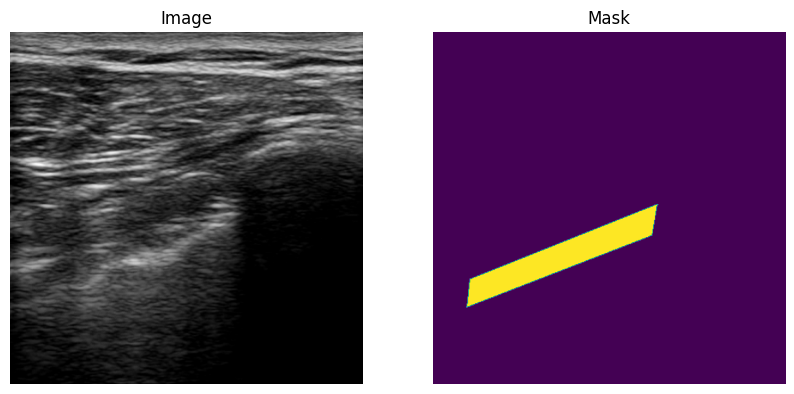

In [27]:
import torch
import matplotlib.pyplot as plt

def show_random_sample(loader):
   # Randomly select an index from the dataset
    idx = torch.randint(0, len(loader.dataset), (1,))
    print(int(idx))
    # Get the random sample from the dataset
    sample = loader.dataset[int(idx)]
    
    # # Extract the input and target from the sample
    # inputs, masks = sample
    
    # # Randomly select an index within the batch
    # idx = torch.randint(0, inputs.shape[0], (1,))
    

    # Assuming inputs[0] contains the image and inputs[1] contains the mask
    image = sample[0].permute(1, 2, 0)  # Assuming inputs[0] is in the format (C, H, W), permute to (H, W, C)
    mask = sample[1].permute(1, 2, 0)   # Assuming inputs[1] is in the format (C, H, W), permute to (H, W, C)

    
    # Display the image and mask
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.show()



# Example usage:
show_random_sample(loaders["train"])


## Jaccard Loss and Dice Loss Explanation
### Binary Cross-Entropy

Binary Cross-Entropy (BCE) loss is a commonly used loss function for binary classification tasks. It measures the dissimilarity between two probability distributions, typically the predicted probabilities and the true labels.

The BCE loss is calculated as follows:

For each prediction, it applies the sigmoid activation function to ensure the predicted values are in the range [0, 1], representing probabilities.
Then, it computes the Binary Cross-Entropy loss between the predicted probabilities and the true binary labels.
BCE loss penalizes the model based on the difference between predicted probabilities and true labels. It encourages the model to output probabilities close to 1 for positive examples and close to 0 for negative examples.

### Jaccard Loss:
The Jaccard index, also known as the Intersection over Union (IoU), is a measure of the similarity between two sets. In the context of segmentation tasks (such as image segmentation), the Jaccard index quantifies the overlap between the predicted segmentation and the ground truth segmentation.

Jaccard loss is a loss function derived from the Jaccard index. It measures the dissimilarity between two sets by calculating the ratio of the intersection of the sets to their union. The Jaccard loss is computed as: Jaccard Loss = 1 - (Intersection / Union)


Where:
- **Intersection**: Number of common elements between the predicted segmentation and the ground truth segmentation.
- **Union**: Total number of elements in both the predicted and ground truth segmentations.

The Jaccard loss penalizes the model when the predicted segmentation deviates from the ground truth segmentation, encouraging the model to produce segmentations with higher overlap with the ground truth.

### Dice Loss:

The Dice coefficient, also known as the Sørensen-Dice coefficient, is another measure of the similarity between two sets. Like the Jaccard index, it is commonly used in segmentation tasks to evaluate the overlap between the predicted segmentation and the ground truth segmentation.

Dice loss is a loss function derived from the Dice coefficient. It is calculated as:
Dice Loss = 1 - (2 * Intersection + ε) / (Total Predicted + Total Targets + ε)

Where:
- **Intersection**: Number of common elements between the predicted segmentation and the ground truth segmentation.
- **Total Predicted**: Total number of elements in the predicted segmentation.
- **Total Targets**: Total number of elements in the ground truth segmentation.
- **ε**: A small constant added to the denominator to avoid division by zero.

Similar to the Jaccard loss, the Dice loss encourages the model to produce segmentations with higher overlap with the ground truth. It penalizes deviations between the predicted and ground truth segmentations by measuring the dissimilarity between them.

Both Jaccard loss and Dice loss are commonly used as loss functions in tasks involving segmentation, such as medical image analysis, object detection, and scene understanding. They are effective in guiding the training process towards producing accurate segmentations.



In [28]:
bce = nn.BCELoss().to(device)
iou = JaccardLoss().to(device)
dice = DiceLoss().to(device)

## Train / Validation pipeline 

### Import Statements
Import necessary libraries and modules.

### Setup for Logging
Define types and losses for logging with Weights & Biases (wandb).

### Criterion Selection
Depending on the `loss_type`, select the appropriate loss function to use during training.

### Initialization
Initialize variables for tracking model performance and early stopping.

### Training Loop
- Iterate over epochs.
- Set the model to train mode.
- Iterate over training data and perform forward pass, backward pass, and optimization steps.
- Decay the learning rate using the scheduler.

### Validation
Compute validation loss metrics (BCE, IOU, Dice) for evaluation.

In PyTorch, when you call model.eval(), you're essentially setting the model to evaluation mode. This mode is used during inference or validation phases rather than training. When the model is in evaluation mode, certain operations like dropout and batch normalization behave differently compared to training mode.

Additionally, torch.no_grad() is a context manager provided by PyTorch. When you enter this context, any operations performed within it won't track gradients. This is useful during inference or validation when you don't need to compute gradients for parameter updates. By using torch.no_grad(), you can reduce memory consumption and speed up computations.

### Model Checkpointing
Save the model if the validation loss improves.

### Logging and Early Stopping
- Log epoch statistics and metrics to wandb.
- Implement early stopping to prevent overfitting.

### Finalization
Log the final loss and finish logging with wandb.

### Summary
Overall, this code trains a deep learning model for lung segmentation, tracks performance, and logs metrics for analysis using Weights & Biases. It includes mechanisms like early stopping to prevent overfitting and model checkpointing to save the best-performing model.


In [29]:
import time
import numpy as np
from tqdm import tqdm

# Define experiment - types and losses for wandb logging
types = ["Pleura", "Aline", "Bline"]
losses = ["BCE", "IOU", "DICE"]


# Set criterion based on loss_type
if loss_type == 0:
    criterion = bce  # Binary Cross-Entropy Loss for classification
elif loss_type == 1:
    criterion = iou  # Intersection over Union Loss
elif loss_type == 2:
    criterion = dice  # Dice Loss

# Initialize variables for model performance tracking
val_loss_min = np.inf  # Variable to keep track of the best model's performance
counter = 10  # Counter for early stopping

# Start logging with Weights & Biases (wandb)
# wandb.init(
#     project="Lung",
#     config={
#         "learning_rate": lr,
#         "Model": "Unet",
#         "fold": fold,
#         "type": types[tp],
#         "loss_type": losses[loss_type]
#     }
# )

# Training loop
for epoch in range(1):

    #####  Train segment #####
    start = time.time()  # Record start time for epoch
    model.train()  # Set the model to train mode
    ls = []  # List to save classification loss
    for inputs, labels in tqdm(loaders["train"]):  # Iterate over training data
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs) 
        loss = criterion(out, labels)  # Calculate classification error
        loss.backward()  # Backpropagate gradients
        ls.append(loss.detach().cpu().item())  # Append loss to list
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients
    lr_decay.step()  # Decay learning rate

    # Compute average training loss
    ls = sum(ls) / len(ls)

    #####  Validation segment #####
    bce_val = []
    iou_val = []
    dice_val = []

    # Sets the model to evaluation mode. In this mode, the model behaves differently compared to training mode.
    # During evaluation mode, operations like dropout and batch normalization layers work differently, usually by deactivating dropout and using running statistics for batch normalization.
    with torch.no_grad():
        model.eval() 
        for inputs, labels in loaders["val"]:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            bce_val.append(bce(out, labels).detach().cpu().item())
            iou_val.append(iou(out, labels).detach().cpu().item())
            dice_val.append(dice(out, labels).detach().cpu().item())

    # Compute average validation losses
    bce_val = sum(bce_val) / len(bce_val)
    iou_val = sum(iou_val) / len(iou_val)
    dice_val = sum(dice_val) / len(dice_val)

    # Select appropriate validation loss based on loss_type
    if loss_type == 0:
        val_loss = bce_val
    elif loss_type == 1:
        val_loss = iou_val
    elif loss_type == 2:
        val_loss = dice_val

    # Save the model if it improves
    # Note:
    # - This code implements a form of early stopping.
    # - It checks if the current validation loss (`val_loss`) is lower than the minimum validation loss seen so far (`val_loss_min`).
    # - If an improvement is detected, it resets the `counter` variable to a predefined value (10).
    # - It then updates `val_loss_min` to the current validation loss.
    # - Finally, it saves the model's parameters to a file if an improvement is detected, using `torch.save()`.
    # - The filename is constructed based on the fold number (`fold`), type (`tp`), and loss type (`loss_type`).
    # - Saving the model at this point ensures that the best-performing version of the model is retained.
    if val_loss_min > val_loss:
        counter = 10
        val_loss_min = val_loss
        torch.save(model.state_dict(), str(fold) + "_" + str(tp) + "_" + str(loss_type) + ".mo")

    # Log epoch statistics
    print(
        "Epoch %d, train_loss %4.4f, bce_val %4.4f, iou_val %4.4f, dice_val %4.4f, time %4.2f" % (
            epoch, ls, bce_val, iou_val, dice_val, time.time() - start))

    # Log metrics to wandb
    # wandb.log({"train_loss": ls, "val_loss": val_loss, "bce_val": bce_val, "iou_val": iou_val, "dice_val": dice_val, "time": time.time() - start})

    # Early stopping mechanism
    if counter == 0:
        break
    counter -= 1

# Log final loss and finish logging
# wandb.config["final_loss"] = val_loss_min
# wandb.finish()


100%|██████████| 396/396 [06:26<00:00,  1.03it/s]


Epoch 0, train_loss 0.1033, bce_val 0.0408, iou_val 0.7127, dice_val 0.5598, time 418.42


In [ ]:
# if __name__ == '__main__':
#     cd = int(sys.argv[1])
#     device = "cuda:" + sys.argv[1]
#     for i in range(5):
#         for j in range(3):
#             for k in range(3):
#                 #if i*9+j*3+k % 2 == cd:
#                 seed = 42
#                 torch.manual_seed(seed)
#                 torch.cuda.manual_seed(seed)
#                 torch.backends.cudnn.deterministic = True
#                 torch.backends.cudnn.benchmark = False
#                 np.random.seed(seed)
#                 #pretrained = int(sys.argv[1]) > 0
#                 train(fold=i, tp=j, loss_type=k)

In [ ]:
!conda env list

# conda environments:
#
base                     /home/mh731nk/anaconda3
mh731nk_apvv-lung-eval  *  /home/mh731nk/anaconda3/envs/mh731nk_apvv-lung-eval



Sample Index: 260


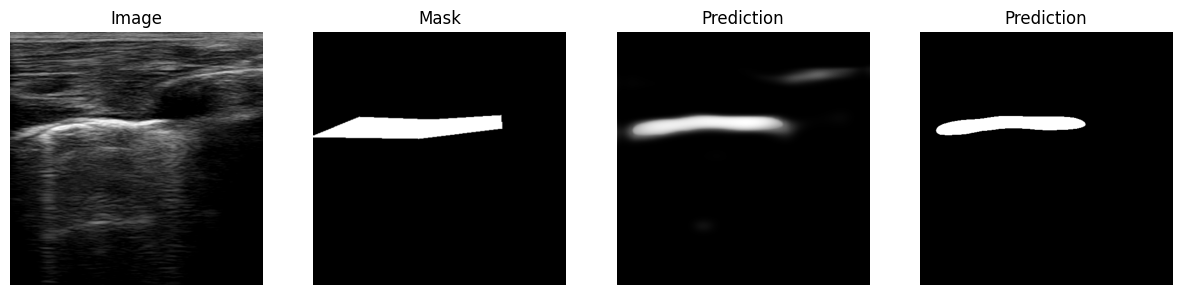

In [32]:
import torch
import matplotlib.pyplot as plt

def show_random_sample(loader, model=None):
    """
    Display a random sample from the dataset along with the ground truth mask and, optionally, the model prediction.

    Args:
    - loader (DataLoader): DataLoader object containing the dataset.
    - model (nn.Module, optional): Segmentation model to make predictions. Defaults to None.
    """
    # Randomly select an index from the dataset
    idx = torch.randint(0, len(loader.dataset), (1,))
    print("Sample Index:", int(idx))
    
    # Get the random sample from the dataset
    sample = loader.dataset[int(idx)]
    
    # Extract the input and target from the sample
    inputs, masks = sample
    
    # Assuming inputs[0] contains the image and inputs[1] contains the mask
    image = inputs.permute(1, 2, 0)  # Assuming inputs is in the format (C, H, W), permute to (H, W, C)
    mask = masks.permute(1, 2, 0)    # Assuming masks is in the format (C, H, W), permute to (H, W, C)
    
    # Display the image and mask
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(image.cpu(), cmap="gray")
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(mask.cpu(), cmap="gray")
    plt.title('Mask')
    plt.axis('off')

    # If model is provided, make prediction and display it
    if model:
        model.eval()
        with torch.no_grad():
            # Assuming the model returns segmentation predictions
            prediction = model(inputs.to(device))  # Assuming the model takes (N, C, H, W) input shape
            # prediction = torch.argmax(prediction, dim=1)  # Assuming prediction is one-hot encoded, select class with highest probability
            
            # Assuming prediction is a tensor with shape (1, H, W)
            # prediction = prediction.squeeze(0)  # Remove batch dimension
            plt.subplot(1, 4, 3)
            plt.imshow(prediction.cpu()[0], cmap="gray")
            plt.title('Prediction')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(prediction.cpu()[0] >0.5, cmap="gray")
            plt.title('Prediction')
            plt.axis('off')
    
    plt.show()

# Example usage:
show_random_sample(loaders["val"], model)


# Unet++


In [10]:
model = UNetPlusPlusFake().to(device)

NameError: name 'UNetPlusPlusFake' is not defined

In [9]:
import time
import numpy as np
from tqdm import tqdm

# Define experiment - types and losses for wandb logging
types = ["Pleura", "Aline", "Bline"]
losses = ["BCE", "IOU", "DICE"]

# Set criterion based on loss_type
if loss_type == 0:
    criterion = bce  # Binary Cross-Entropy Loss for classification
elif loss_type == 1:
    criterion = iou  # Intersection over Union Loss
elif loss_type == 2:
    criterion = dice  # Dice Loss

# Initialize variables for model performance tracking
val_loss_min = np.inf  # Variable to keep track of the best model's performance
counter = 10  # Counter for early stopping

# Training loop
for epoch in range(1):

    #####  Train segment #####
    start = time.time()  # Record start time for epoch
    model.train()  # Set the model to train mode
    ls = []  # List to save classification loss
    for inputs, labels in tqdm(loaders["train"]):  # Iterate over training data
        inputs, labels = inputs.to(device), labels.to(device)
        output, [feat1, feat2, feat3, feat4] = model(inputs)  # Get output and features from model
        loss = criterion(output, labels)  # Calculate segmentation error
        loss.backward()  # Backpropagate gradients
        ls.append(loss.detach().cpu().item())  # Append loss to list
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Reset gradients
    lr_decay.step()  # Decay learning rate

    # Compute average training loss
    ls = sum(ls) / len(ls)

    #####  Validation segment #####
    val_loss = 0
    with torch.no_grad():
        model.eval()  # Sets the model to evaluation mode
        for inputs, labels in loaders["val"]:
            inputs, labels = inputs.to(device), labels.to(device)
            output, _ = model(inputs)  # Get output from model
            val_loss += criterion(output, labels).item()  # Accumulate validation loss

    # Compute average validation loss
    val_loss /= len(loaders["val"])

    # Save the model if it improves
    if val_loss_min > val_loss:
        counter = 10
        val_loss_min = val_loss
        torch.save(model.state_dict(), str(fold) + "_" + str(tp) + "_" + str(loss_type) + ".mo")

    # Log epoch statistics
    print(
        "Epoch %d, train_loss %4.4f, val_loss %4.4f, time %4.2f" % (
            epoch, ls, val_loss, time.time() - start))

    # Early stopping mechanism
    if counter == 0:
        break
    counter -= 1


100%|██████████| 396/396 [01:47<00:00,  3.68it/s]


Epoch 0, train_loss 0.2480, val_loss 0.1639, time 118.31


In [11]:
feat1.shape

torch.Size([14, 256, 64, 64])